In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import  r2_score
from sklearn.linear_model import LinearRegression


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)

# Preview data and choose features

In [3]:
preview_df = pd.read_csv('Data/historic.csv')
preview_df.head()

,name,FIX_season,FIX_team,FIX_GW,FIX_Fixture_date,FIX_Opponent,FIX_Home?,FIX_goals_marginal,FIX_goals_cumulative,FIX_opp_goals,FIX_points_marginal,FIX_points_cumulative,FIX_opponent_goals_cumulative,FIX_opponent_points_cumulative,INCOMING_team_points,INCOMING_opponent_points,INCOMING_team_goals,INCOMING_opponent_goals,FIX_points_diff,FIX_goals_diff,FIX_team_code,FIX_opponent_team,FIX_opponent_code,Season,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,file,fixture,fouls,goals_conceded,goals_scored,ict_index,id_x,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,position,id_y,forecast,cost_today,LW_total_points,L4W_total_points,TSS_total_points,LW_goals_scored,L4W_goals_scored,TSS_goals_scored,LW_minutes,L4W_minutes,TSS_minutes,LW_bps,L4W_bps,TSS_bps,LW_ict_index,L4W_ict_index,TSS_ict_index,LW_influence,L4W_influence,TSS_influence,LW_creativity,L4W_creativity,TSS_creativity,LW_threat,L4W_threat,TSS_threat,LW_clean_sheets,L4W_clean_sheets,TSS_clean_sheets
0,Aaron_Connolly,2019-20,Brighton,4,2019-08-31 00:00:00,Man City,0,0.0,4.0,4.0,0.0,4.0,14.0,10.0,4.0,4.0,4.0,3.0,0.0,1.0,4.0,Man City,11.0,2019-20,0.0,NaN,NaN,NaN,0.0,1.0,0.0,NaN,NaN,0.1,NaN,NaN,534.0,NaN,NaN,/Users/calumthompson/Documents/Fantasy_footbal...,37.0,NaN,1.0,0.0,0.0,NaN,0.2,NaN,2019-08-31 14:00:00,NaN,NaN,NaN,24.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,4.0,0.0,0.0,NaN,NaN,NaN,0.0,4.0,0.0,1.0,0.0,0.0,0.0,45.0,False,NaN,0.0,4.0,534.0,0,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron_Connolly,2019-20,Brighton,5,2019-09-14 00:00:00,Burnley,1,1.0,5.0,1.0,1.0,5.0,6.0,6.0,4.0,10.0,4.0,14.0,-6.0,-10.0,4.0,Burnley,5.0,2019-20,0.0,NaN,NaN,NaN,0.0,1.0,0.0,NaN,NaN,0.3,NaN,NaN,534.0,NaN,NaN,/Users/calumthompson/Documents/Fantasy_footbal...,43.0,NaN,1.0,0.0,2.2,NaN,1.0,NaN,2019-09-14 14:00:00,NaN,NaN,NaN,6.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,5.0,0.0,14029.0,NaN,NaN,NaN,1.0,1.0,21.0,1.0,10589.0,13500.0,2911.0,45.0,True,NaN,0.0,4.0,534.0,0,42.0,1.0,1.0,1.0,0.0,0.0,0.0,24.0,24.000000,24.000000,1.0,1.00,1.00,0.0,0.000000,0.000000,0.2,0.200000,0.200000,0.1,0.100000,0.100000,0.0,0.00,0.00,0.0,0.0,0.0
2,Aaron_Connolly,2019-20,Brighton,6,2019-09-21 00:00:00,Newcastle,0,0.0,5.0,0.0,1.0,6.0,4.0,7.0,5.0,6.0,5.0,6.0,-1.0,-1.0,4.0,Newcastle,13.0,2019-20,0.0,NaN,NaN,NaN,0.0,1.0,0.0,NaN,NaN,4.8,NaN,NaN,534.0,NaN,NaN,/Users/calumthompson/Documents/Fantasy_footbal...,58.0,NaN,0.0,0.0,2.5,NaN,2.0,NaN,2019-09-21 16:30:00,NaN,NaN,NaN,20.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,6.0,0.0,22804.0,NaN,NaN,NaN,0.0,0.0,18.0,1.0,8090.0,11749.0,3659.0,45.0,False,NaN,0.0,4.0,534.0,0,42.0,1.0,1.0,1.0,0.0,0.0,0.0,6.0,15.000000,15.000000,1.0,1.00,1.00,2.2,1.100000,1.100000,1.0,0.600000,0.600000,0.3,0.200000,0.200000,21.0,10.50,10.50,0.0,0.0,0.0
3,Aaron_Connolly,2019-20,Brighton,7,2019-09-28 00:00:00,Chelsea,0,0.0,5.0,2.0,0.0,6.0,14.0,12.0,6.0,7.0,5.0,4.0,-1.0,1.0,4.0,Chelsea,6.0,2019-20,0.0,NaN,NaN,NaN,0.0,2.0,0.0,NaN,NaN,0.6,NaN,NaN,534.0,NaN,NaN,/Users/calumthompson/Documents/Fantasy_footbal...,63.0,NaN,1.0,0.0,0.1,NaN,0.2,NaN,2019-09-28 14:00:00,NaN,NaN,NaN,25.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,7.0,0.0,32699.0,NaN,NaN,NaN,0.0,2.0,0.0,1.0,8437.0,13439.0,5002.0,45.0,False,NaN,0.0,4.0,534.0,0,42.0,1.0,1.0,1.0,0.0,0.0,0.0,20.0,16.666667,16.666667,1.0,1.00,1.00,2.5,1.566667,1.566667,2.0,1.066667,1.066667,4.8,1.733333,1.733333,18.0,13.00,13.00,0.0,0.0,0.0
4,Aaron_Connolly,2019-20,Brighton,8,2019-10-05 00:00:00,Spurs,1,3.0,8.0,0.0,3.0,9.0,14.0,12.0,6.0,12.0,5.0,

In [4]:
np.abs(preview_df.corr()['total_points']).sort_values(ascending = False).head(10)

total_points        1.000000
bps                 0.906439
influence           0.830298
ict_index           0.758408
bonus               0.749934
goals_scored        0.662809
minutes             0.634307
clean_sheets        0.583493
attempted_passes    0.546575
threat              0.545262
Name: total_points, dtype: float64

In [5]:
model_columns = ['name',
                 'position',
                 'FIX_team',
                 'FIX_Opponent',
                 'FIX_Home?', 
                 'FIX_GW', 
                 'FIX_season',
#                  'minutes',
                 'total_points',
                 'INCOMING_team_goals',
                 'INCOMING_opponent_goals',
                 'INCOMING_team_points',
                 'INCOMING_opponent_points',
                 'FIX_points_diff',
                 'FIX_goals_diff',
                 'L4W_total_points',
                 'TSS_total_points',
                 'L4W_goals_scored',
                 'TSS_goals_scored',
                 'L4W_minutes',
                 'TSS_minutes',
                 'cost_today',
                 'value',
                 'L4W_bps',
                 'TSS_bps',
                 'L4W_ict_index',
                 'TSS_ict_index',
                 'L4W_influence',
                 'TSS_influence',
                 'L4W_creativity',
                 'TSS_creativity',
                 'L4W_threat',
                 'TSS_threat',
                 'L4W_clean_sheets',
                 'TSS_clean_sheets'
                 ]

print(len(model_columns), 'features')

34 features


# Prepare dataset
- Player
- Position
- Team
- Opposition
- Home/away
- Gameweek
- Season
- Minutes

In [6]:
historic_df = pd.read_csv('Data/historic.csv').dropna(subset = model_columns)

historic_df = historic_df.drop_duplicates(subset = model_columns)

print("Includes seasons: " ,historic_df['FIX_season'].unique())

historic_df.head()


Includes seasons:  ['2019-20' '2016-17' '2017-18' '2018-19']


,name,FIX_season,FIX_team,FIX_GW,FIX_Fixture_date,FIX_Opponent,FIX_Home?,FIX_goals_marginal,FIX_goals_cumulative,FIX_opp_goals,FIX_points_marginal,FIX_points_cumulative,FIX_opponent_goals_cumulative,FIX_opponent_points_cumulative,INCOMING_team_points,INCOMING_opponent_points,INCOMING_team_goals,INCOMING_opponent_goals,FIX_points_diff,FIX_goals_diff,FIX_team_code,FIX_opponent_team,FIX_opponent_code,Season,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,element,errors_leading_to_goal,errors_leading_to_goal_attempt,file,fixture,fouls,goals_conceded,goals_scored,ict_index,id_x,influence,key_passes,kickoff_time,kickoff_time_formatted,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,round,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,position,id_y,forecast,cost_today,LW_total_points,L4W_total_points,TSS_total_points,LW_goals_scored,L4W_goals_scored,TSS_goals_scored,LW_minutes,L4W_minutes,TSS_minutes,LW_bps,L4W_bps,TSS_bps,LW_ict_index,L4W_ict_index,TSS_ict_index,LW_influence,L4W_influence,TSS_influence,LW_creativity,L4W_creativity,TSS_creativity,LW_threat,L4W_threat,TSS_threat,LW_clean_sheets,L4W_clean_sheets,TSS_clean_sheets
1,Aaron_Connolly,2019-20,Brighton,5,2019-09-14 00:00:00,Burnley,1,1.0,5.0,1.0,1.0,5.0,6.0,6.0,4.0,10.0,4.0,14.0,-6.0,-10.0,4.0,Burnley,5.0,2019-20,0.0,NaN,NaN,NaN,0.0,1.0,0.0,NaN,NaN,0.3,NaN,NaN,534.0,NaN,NaN,/Users/calumthompson/Documents/Fantasy_footbal...,43.0,NaN,1.0,0.0,2.2,NaN,1.0,NaN,2019-09-14 14:00:00,NaN,NaN,NaN,6.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,5.0,0.0,14029.0,NaN,NaN,NaN,1.0,1.0,21.0,1.0,10589.0,13500.0,2911.0,45.0,True,NaN,0.0,4.0,534.0,0,42.0,1.0,1.0,1.0,0.0,0.0,0.0,24.0,24.000000,24.000000,1.0,1.00,1.00,0.0,0.000000,0.000000,0.2,0.200000,0.200000,0.1,0.100000,0.100000,0.0,0.00,0.00,0.0,0.00,0.0
2,Aaron_Connolly,2019-20,Brighton,6,2019-09-21 00:00:00,Newcastle,0,0.0,5.0,0.0,1.0,6.0,4.0,7.0,5.0,6.0,5.0,6.0,-1.0,-1.0,4.0,Newcastle,13.0,2019-20,0.0,NaN,NaN,NaN,0.0,1.0,0.0,NaN,NaN,4.8,NaN,NaN,534.0,NaN,NaN,/Users/calumthompson/Documents/Fantasy_footbal...,58.0,NaN,0.0,0.0,2.5,NaN,2.0,NaN,2019-09-21 16:30:00,NaN,NaN,NaN,20.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,6.0,0.0,22804.0,NaN,NaN,NaN,0.0,0.0,18.0,1.0,8090.0,11749.0,3659.0,45.0,False,NaN,0.0,4.0,534.0,0,42.0,1.0,1.0,1.0,0.0,0.0,0.0,6.0,15.000000,15.000000,1.0,1.00,1.00,2.2,1.100000,1.100000,1.0,0.600000,0.600000,0.3,0.200000,0.200000,21.0,10.50,10.50,0.0,0.00,0.0
3,Aaron_Connolly,2019-20,Brighton,7,2019-09-28 00:00:00,Chelsea,0,0.0,5.0,2.0,0.0,6.0,14.0,12.0,6.0,7.0,5.0,4.0,-1.0,1.0,4.0,Chelsea,6.0,2019-20,0.0,NaN,NaN,NaN,0.0,2.0,0.0,NaN,NaN,0.6,NaN,NaN,534.0,NaN,NaN,/Users/calumthompson/Documents/Fantasy_footbal...,63.0,NaN,1.0,0.0,0.1,NaN,0.2,NaN,2019-09-28 14:00:00,NaN,NaN,NaN,25.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,7.0,0.0,32699.0,NaN,NaN,NaN,0.0,2.0,0.0,1.0,8437.0,13439.0,5002.0,45.0,False,NaN,0.0,4.0,534.0,0,42.0,1.0,1.0,1.0,0.0,0.0,0.0,20.0,16.666667,16.666667,1.0,1.00,1.00,2.5,1.566667,1.566667,2.0,1.066667,1.066667,4.8,1.733333,1.733333,18.0,13.00,13.00,0.0,0.00,0.0
4,Aaron_Connolly,2019-20,Brighton,8,2019-10-05 00:00:00,Spurs,1,3.0,8.0,0.0,3.0,9.0,14.0,12.0,6.0,12.0,5.0,14.0,-6.0,-9.0,4.0,Spurs,17.0,2019-20,0.0,NaN,NaN,NaN,3.0,53.0,1.0,NaN,NaN,23.8,NaN,NaN,534.0,NaN,NaN,/Users/calumthompson/Documents/Fantasy_footbal...,72.0,NaN,0.0,2.0,20.1,NaN,70.2,NaN,2019-10-05 11:30:00,NaN,NaN,NaN,79.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,8.0,0.0,35026.0,NaN,NaN,NaN,0.0,3.0,107.0,13.0,2156.0,5952.0,3796.0,45.0,True,NaN,0.0,4.0,534.0,0,42.0,1.0,1.0,1.0,0.0,0.0,0.0,25.0,18.750000,18.750000,2.0,1.25,1.25,0.1,1.200000,1.200000,0.2,0.850000,0.850000,0.6,1.450000,1.450000,0.0,9.75,9.75,0.0,0.00,0.0
5,Aaron_Connolly,2019-20,Brighton,9,201

In [7]:
historic_df = historic_df.loc[(historic_df['FIX_season'] == '2019-20') & (historic_df['position'] == 1)]

In [8]:
def encode(df):

    for col in df.select_dtypes(exclude = 'number').columns:

        print("Encoding ", col)

        lb_make = LabelEncoder()
        df[col +'_encoded'] = lb_make.fit_transform(df[col].astype(str))
        
        df = df.drop(columns = col)
        
    return df

In [9]:
model_df = encode(historic_df[model_columns])

Encoding  name
Encoding  FIX_team
Encoding  FIX_Opponent
Encoding  FIX_season


/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
train_df, test_df = train_test_split(model_df, test_size=0.33, random_state=42)

In [11]:
y_col = 'total_points'
x_cols = model_df.columns.values[model_df.columns.values != y_col]

In [12]:
X_train = train_df[x_cols]
y_train = train_df[y_col]

In [13]:
X_test = test_df[x_cols]
y_test = test_df[y_col]

In [14]:
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)
StandardScaler(copy=True, with_mean=True, with_std=True)

# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Run fit

In [15]:
def plot_results(y_actual,y_predicted, plot_linear_reference = False):
    
    
    y_predicted = y_predicted.reshape(-1,1)
    y_actual = y_actual.reshape(-1,1)
    
    plt.scatter(y_predicted,y_actual, marker = 'x', alpha = 0.5)
    
    plt.grid()
    plt.xlim(left = 0)
    plt.ylim(bottom = 0)
    
    plt.xlabel('y_predicted')
    plt.ylabel('y_actual')
    
    r2 = r2_score(y_predicted,y_actual)
    
    plt.title("R2: " + str(r2))
    
    if plot_linear_reference:
        
        # Prediction = fit line 
        ref = np.arange(0,140,0.1)
        plt.plot(ref,ref, linestyle = '--' , c = 'k', label = 'Actual = prediction')

        # Show actual LoBF
        Regressor = LinearRegression()
        Regressor.fit(y_predicted,y_actual)
        LOBF = Regressor.predict(y_predicted)
        plt.plot(y_predicted,LOBF,linestyle = '-' , c = 'k', label = 'LoBF')
        
        plt.legend()
        
    
    plt.show()
    
#     print("R2: ", r2_score(y_test, fit))

In [16]:
# # Tune hyper parameters

# mlp = MLPRegressor()
# param_list = {"hidden_layer_sizes": np.arange(5,35,5)
#              ,"max_iter":[5000] 
#              ,"activation": ["identity", "logistic", "tanh", "relu"]}

# gsc = GridSearchCV(estimator=mlp, param_grid=param_list, verbose = 10, n_jobs = -1  )

# grid_result = gsc.fit(X_train, y_train)
# best_params = grid_result.best_params_

# print(best_params)

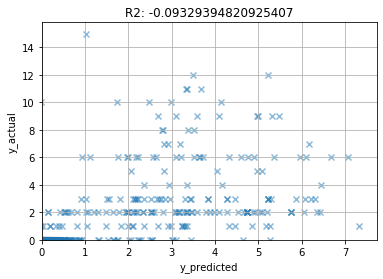

/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/calumthompson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [17]:
mlp = MLPRegressor(max_iter = 5000
                  ,hidden_layer_sizes = (5)
                  ,activation = 'logistic'
                  ,verbose = 0)


mlp.fit(X_train,y_train)
fit = mlp.predict(X_test)

plot_results(y_test.values,fit)

test_df['prediction'] = fit
test_df['test/train'] = 'test'

train_df['prediction'] = mlp.predict(X_train)
train_df['test/train'] = 'train'

In [18]:
predictions_combined = pd.concat([test_df[['prediction','test/train']],train_df[['prediction','test/train']]])

In [19]:
historic_df['prediction'] = predictions_combined['prediction']
historic_df['test/train'] = predictions_combined['test/train']

In [20]:
results_df = historic_df[['name',
                         'position',
                         'FIX_Fixture_date',
                         'FIX_team',
                         'FIX_Opponent',
                         'FIX_Home?', 
                         'FIX_GW', 
                         'FIX_season',
                         'minutes',
                         'total_points',
                         'prediction',
                         'test/train'
                         ]].copy()

In [21]:
results_df.head()

,name,position,FIX_Fixture_date,FIX_team,FIX_Opponent,FIX_Home?,FIX_GW,FIX_season,minutes,total_points,prediction,test/train
456,Aaron_Ramsdale,1.0,2019-08-17 00:00:00,Bournemouth,Aston Villa,0,2,2019-20,90.0,4.0,5.180216,train
457,Aaron_Ramsdale,1.0,2019-08-25 00:00:00,Bournemouth,Man City,1,3,2019-20,90.0,1.0,4.224915,train
458,Aaron_Ramsdale,1.0,2019-08-31 00:00:00,Bournemouth,Leicester,0,4,2019-20,90.0,1.0,4.760625,train
459,Aaron_Ramsdale,1.0,2019-09-15 00:00:00,Bournemouth,Everton,1,5,2019-20,90.0,3.0,4.144316,train
460,Aaron_Ramsdale,1.0,2019-09-20 00:00:00,Bournemouth,Southampton,0,6,2019-20,90.0,10.0,5.267373,train


# Evaluate

In [22]:
def evaluate(eval_df, seasons = None, plot_linear_reference = False):
    
    if seasons is not None:
        eval_df = eval_df.loc[eval_df['FIX_season'].isin(seasons)]

    print("Seasons included :", eval_df['FIX_season'].unique())
    
    eval_df = eval_df.sort_values(['name','FIX_Fixture_date'])

    eval_df = eval_df.groupby(['name','FIX_season'])[['total_points','prediction']].sum().reset_index()
        
    eval_df['rank_actual'] = eval_df['total_points'].rank(ascending = False, method = 'min')
    eval_df['rank_prediction'] = eval_df['prediction'].rank(ascending = False, method = 'min')

    plot_results(eval_df['total_points'].values,eval_df['prediction'].values , plot_linear_reference = plot_linear_reference)
    
    return eval_df.sort_values('prediction', ascending = False).head()
    

Seasons included : ['2019-20']


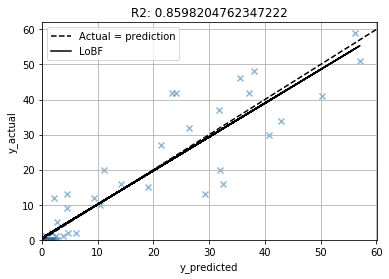

,name,FIX_season,total_points,prediction,rank_actual,rank_prediction
11,Ben_Foster,2019-20,51.0,57.023745,2.0,1.0
58,Rui Pedro_dos Santos PatrÃ­cio,2019-20,59.0,56.093543,1.0,2.0
21,Dean_Henderson,2019-20,41.0,50.168754,8.0,3.0
35,Jordan_Pickford,2019-20,34.0,42.871013,10.0,4.0
47,Martin_Dubravka,2019-20,30.0,40.653613,12.0,5.0


In [23]:
evaluate(results_df.loc[results_df['test/train'] == 'test'], plot_linear_reference = True)

Seasons included : ['2019-20']


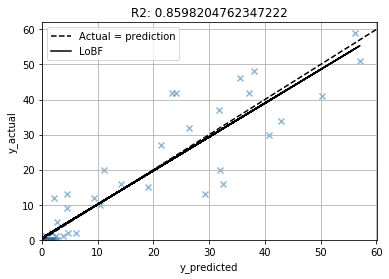

,name,FIX_season,total_points,prediction,rank_actual,rank_prediction
11,Ben_Foster,2019-20,51.0,57.023745,2.0,1.0
58,Rui Pedro_dos Santos PatrÃ­cio,2019-20,59.0,56.093543,1.0,2.0
21,Dean_Henderson,2019-20,41.0,50.168754,8.0,3.0
35,Jordan_Pickford,2019-20,34.0,42.871013,10.0,4.0
47,Martin_Dubravka,2019-20,30.0,40.653613,12.0,5.0


In [24]:
evaluate(results_df.loc[results_df['test/train'] == 'test'], seasons = ['2019-20'], plot_linear_reference = True)

# Output forecast

In [25]:
# combined_df.to_csv('Data/historic_with_forecast.csv',index = False)